[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\folan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Loading and preprocessing tweets...

Sample of cleaned tweets:
                                      original_tweet  \
0  @GailAlfarATX @elonmusk @Tesla @teslacn @Tesla...   
1  @elonmusk @GailAlfarATX @Tesla @teslacn @Tesla...   
2  @elonmusk #Think about buying a country , #Mex...   
3  @get_innocuous Actual receipts, and yet you ha...   
4  Tesla wall battery for the save! Power went ou...   

                                       cleaned_tweet  
0  I have six  of them still live at home being h...  
1  Then go for your dozen kids you are just missi...  
2  Think about buying a country  Mexico  You coul...  
3  Actual receipts and yet you havent asked anyon...  
4  Tesla wall battery for the save Power went out...  
--------------------------------------------------
VADER sentiment analysis:

BERT sentiment analysis:
Processed 0/10016 tweets
Processed 800/10016 tweets
Processed 1600/10016 tweets
Processed 2400/10016 tweets
Processed 3200/10016 tweets
Processed 4000/10016 tweets
Pro

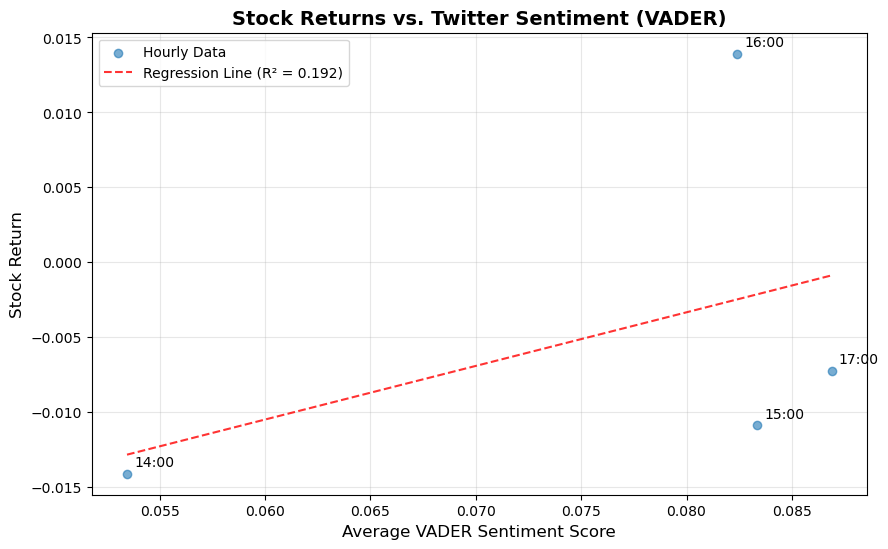

<Figure size 640x480 with 0 Axes>

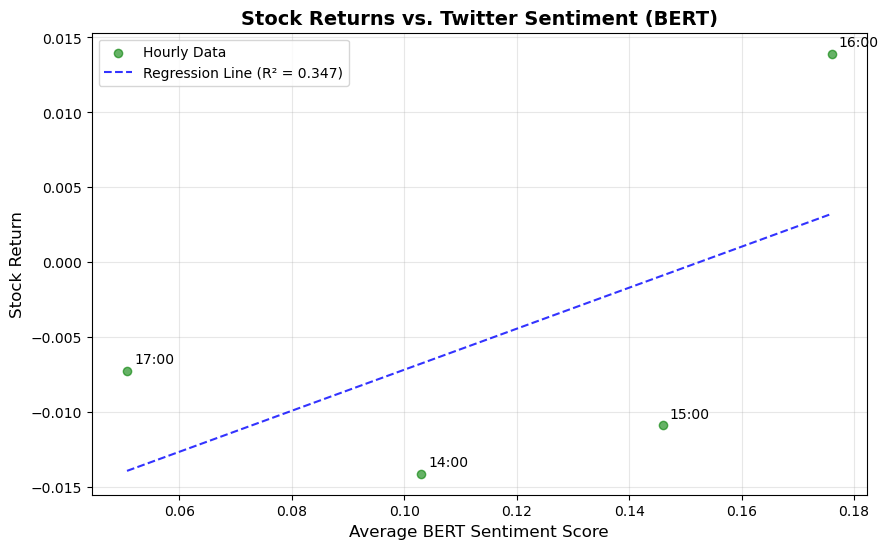

c:\Users\folan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 640x480 with 0 Axes>

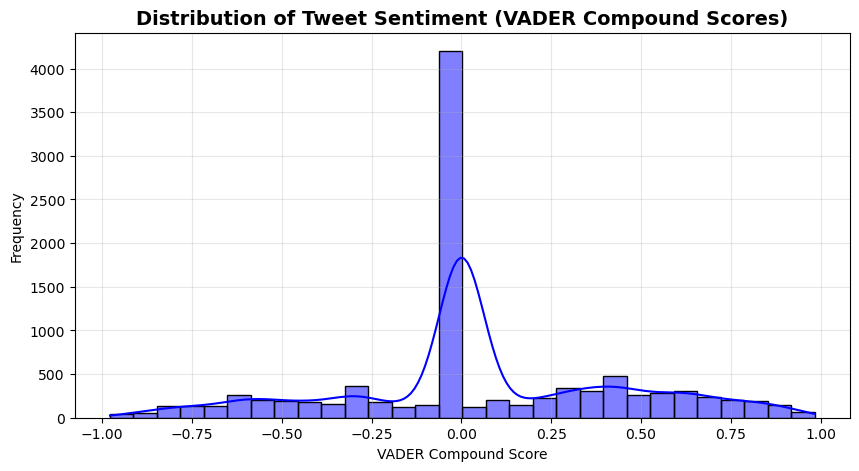

c:\Users\folan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 640x480 with 0 Axes>

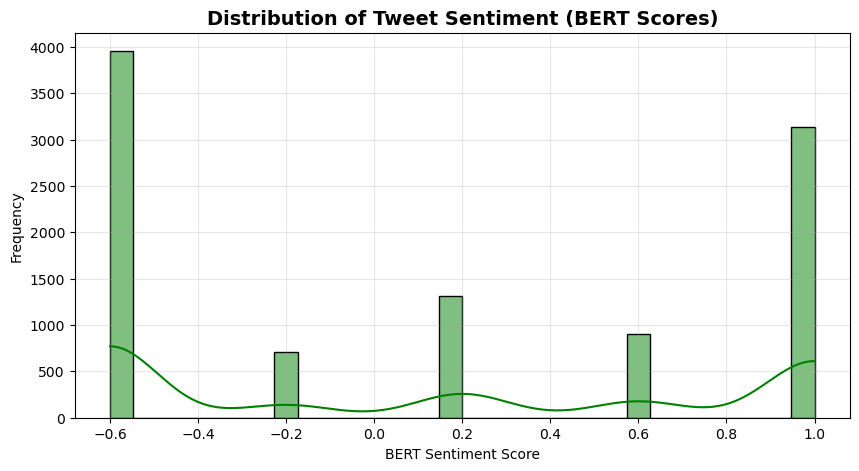

<Figure size 640x480 with 0 Axes>

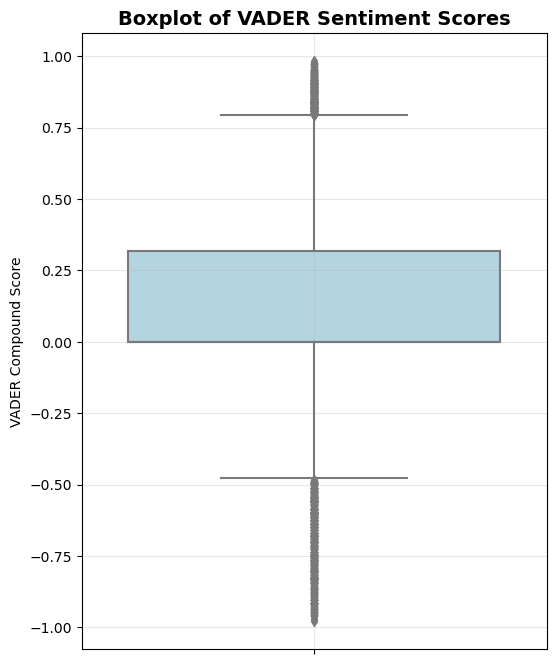

<Figure size 640x480 with 0 Axes>

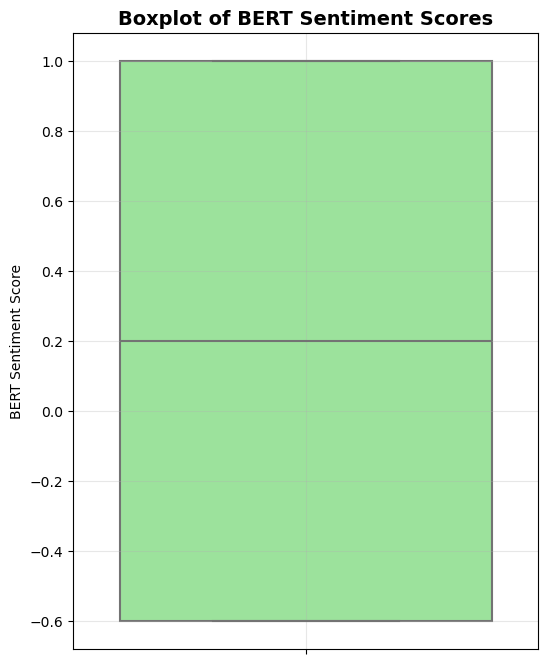

<Figure size 640x480 with 0 Axes>

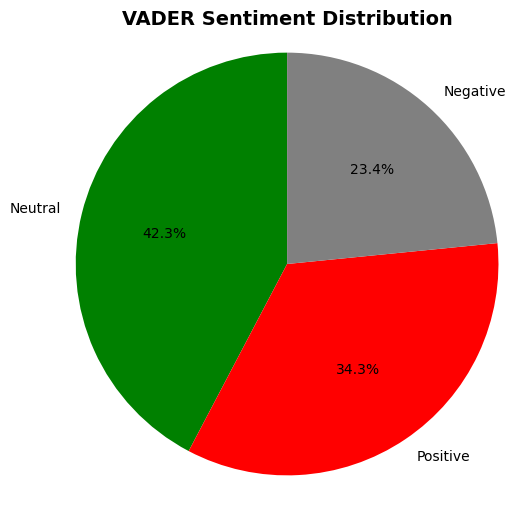

<Figure size 640x480 with 0 Axes>

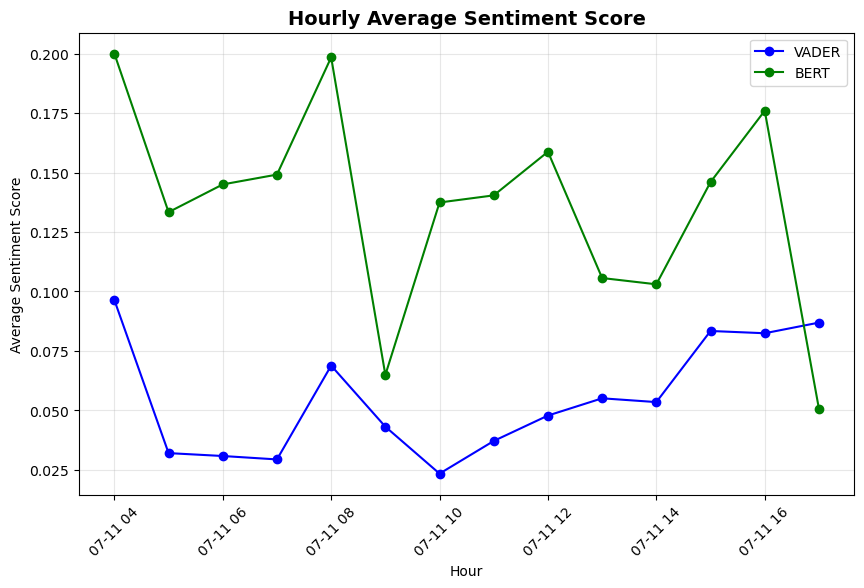

<Figure size 640x480 with 0 Axes>

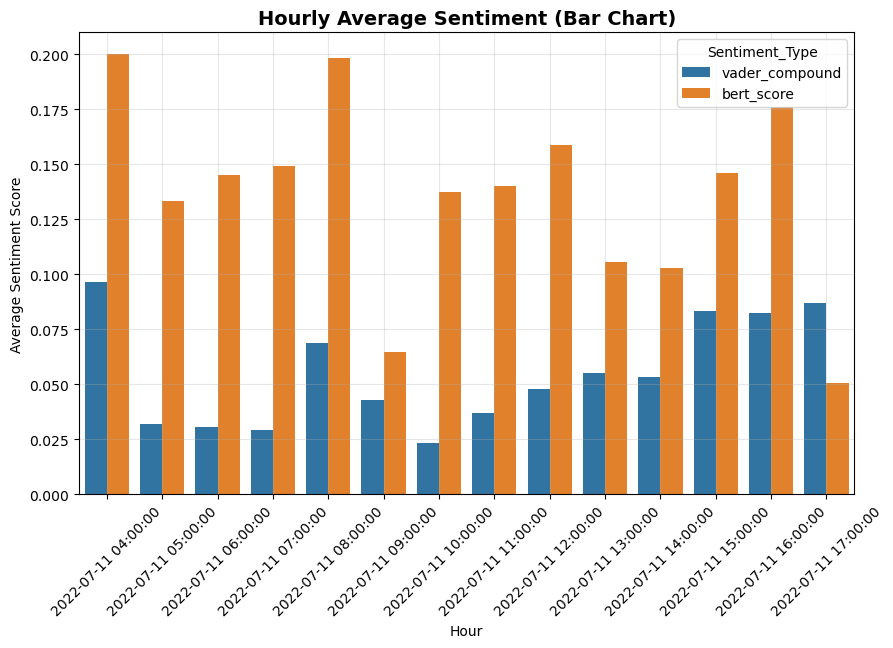

Top 5 Most Negative Tweets:
--------------------------------------------------
Rank 1: Sentiment = -0.978 | Tweet: Elon musk can taste my fat toes, he is a bitch and I hate him, also fuck tesla. Ever wonder why the police, firemen, ambulance drivers never drive electric cars? The UK tried electric police cars and they failed miserably. 🖕🖕🖕 SUCK MY DICK ELON
Rank 2: Sentiment = -0.970 | Tweet: @JoeMagnus74 @Forbes He was for sure wrong on Solar city. And wrong again with PayPal. Wrong with Tesla. Wrong with space x. He is wrong for trying to buy Twitter. He is wrong for building the gigs factories. He is wrong… maybe you’re wrong??
Rank 3: Sentiment = -0.961 | Tweet: @elonmusk You really need to stop making a fool of yourself with the Twitter disaster, and try to focus on helping Tesla recover from your self inflicted damage.  Pay the penalty to end the debacle of putting yourself up as the poster boy for White Supremacists on Twitter.  #Fascist
Rank 4: Sentiment = -0.959 | Tweet: Elon 

<Figure size 640x480 with 0 Axes>

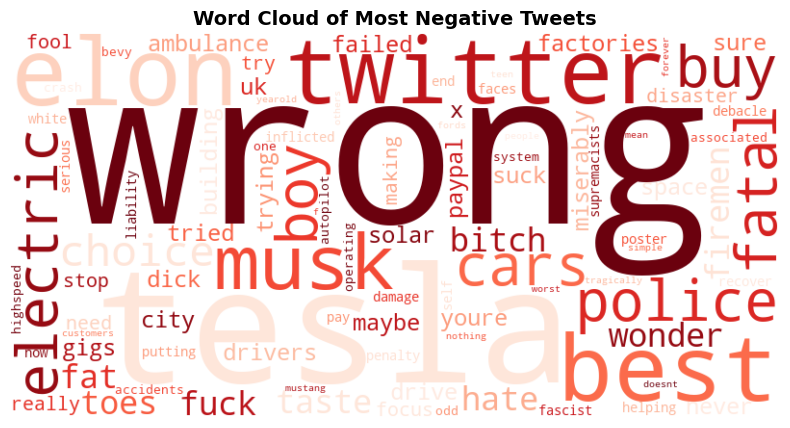

<Figure size 640x480 with 0 Axes>

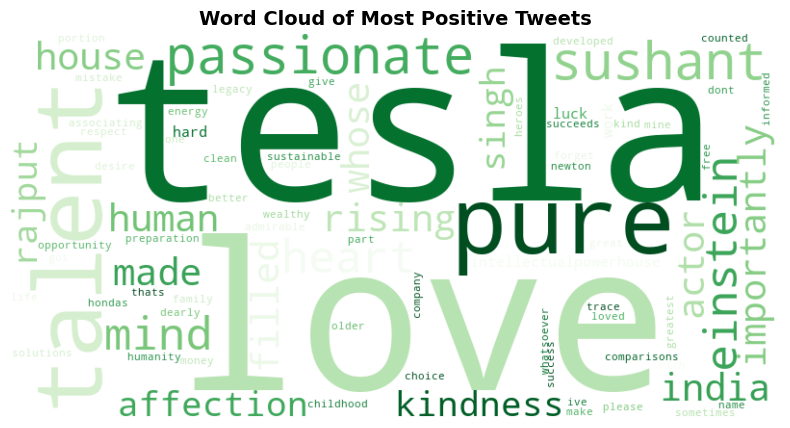

<Figure size 640x480 with 0 Axes>

In [3]:
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from scipy import stats
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
import nltk

nltk.download('vader_lexicon')

# Load and Preprocess Tweets
print("Loading and preprocessing tweets...")
tweets_data = pd.read_csv('Tesla.csv')
tweets_data['timestamp'] = pd.to_datetime(tweets_data['date'])
tweets_data['hour'] = tweets_data['timestamp'].dt.floor('H')

cleaned_data = pd.DataFrame()
cleaned_data['original_tweet'] = tweets_data['tweet']
cleaned_data['timestamp'] = tweets_data['timestamp']
cleaned_data['hour'] = tweets_data['hour']
cleaned_data['cleaned_tweet'] = ""
cleaned_data['vader_compound'] = 0.0
cleaned_data['bert_score'] = 0.0

# Preprocess tweets
def preprocess_tweet(tweet):
    tweet = str(tweet)
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'@\w+', '', tweet)  # Remove mentions
    tweet = re.sub(r'#', '', tweet)  # Remove hashtags
    tweet = re.sub(r'[^\w\s]', '', tweet)  # Remove special characters
    tweet = re.sub(r'\d+', '', tweet)  # Remove numbers
    tweet = tweet.strip()  # Remove leading/trailing whitespace
    return tweet

cleaned_data['cleaned_tweet'] = tweets_data['tweet'].apply(preprocess_tweet)

print("\nSample of cleaned tweets:")
print(cleaned_data[['original_tweet', 'cleaned_tweet']].head())
print("-" * 50)

# Sentiment Analysis

# VADER Analysis
print("VADER sentiment analysis:")
sentiment_analyzer = SentimentIntensityAnalyzer()
cleaned_data['vader_compound'] = cleaned_data['cleaned_tweet'].apply(
    lambda x: sentiment_analyzer.polarity_scores(x)['compound']
)

# BERT Analysis
print("\nBERT sentiment analysis:")
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

def get_bert_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    scores = F.softmax(outputs.logits, dim=1)
    # Convert 5-class sentiment to [-1, 1] range
    score = (scores.argmax().item() + 1) / 5 * 2 - 1
    return score

# Process in batches
batch_size = 32
for i in range(0, len(cleaned_data), batch_size):
    batch = cleaned_data['cleaned_tweet'][i:i+batch_size].tolist()
    batch_scores = [get_bert_sentiment(tweet) for tweet in batch]
    cleaned_data.loc[i:i+batch_size-1, 'bert_score'] = batch_scores
    if i % 100 == 0:
        print(f"Processed {i}/{len(cleaned_data)} tweets")

print("\nSentiment Analysis Summary:")
print(f"Average VADER Score: {cleaned_data['vader_compound'].mean():.3f}")
print(f"Average BERT Score: {cleaned_data['bert_score'].mean():.3f}")

# Aggregate hourly sentiment scores
hourly_sentiment = cleaned_data.groupby('hour').agg({
    'vader_compound': 'mean',
    'bert_score': 'mean',
    'cleaned_tweet': 'count'
}).reset_index()
hourly_sentiment.rename(columns={'cleaned_tweet': 'tweet_count'}, inplace=True)

print("\nHourly Sentiment Summary:")
print(hourly_sentiment.head())
print("-" * 50)

# Load and Process Stock Data
print("Loading and preprocessing stock data...")
stock_data = pd.read_csv('TSLA_stock_data.csv')
stock_data.columns = stock_data.columns.str.lower()

common_date = pd.to_datetime(tweets_data['date'].iloc[0]).date()
stock_data['timestamp'] = pd.to_datetime(str(common_date) + ' ' + stock_data['time'])
stock_data['hour'] = stock_data['timestamp'].dt.floor('H')
stock_data['return'] = pd.to_numeric(stock_data['price'], errors='coerce').pct_change()

print("\nStock Data:")
print(stock_data[['time', 'price', 'return']].to_string())
print("-" * 50)

# Merge and Correlate
print("\nMerging data and calculating correlations...")
merged_data = pd.merge(hourly_sentiment, stock_data, on='hour', how='inner')
valid_data = merged_data.dropna(subset=['return'])

# Calculate correlations
vader_corr, vader_p = stats.pearsonr(valid_data['vader_compound'], valid_data['return'])
bert_corr, bert_p = stats.pearsonr(valid_data['bert_score'], valid_data['return'])

print("\nCorrelation Results:")
print("-" * 50)
print("VADER Analysis:")
print(f"Correlation: {vader_corr:.3f}")
print(f"P-value: {vader_p:.3f}")
print(f"R-squared: {vader_corr**2:.3f}")

print("\nBERT Analysis:")
print(f"Correlation: {bert_corr:.3f}")
print(f"P-value: {bert_p:.3f}")
print(f"R-squared: {bert_corr**2:.3f}")

# Detailed Hourly Analysis
print("\nDetailed Hourly Analysis:")
print("-" * 80)
print("Hour | Return  | VADER Score | BERT Score | Tweet Count")
print("-" * 80)
for _, row in valid_data.iterrows():
    print(f"{row['hour'].hour:02d}:00 | {row['return']:7.3%} | {row['vader_compound']:11.3f} | "
          f"{row['bert_score']:10.3f} | {row['tweet_count']:11d}")


# Visualizations
print("\nCreating visualizations...")

# Sentiment vs Return (VADER)
plt.figure(figsize=(10, 6))
plt.scatter(valid_data['vader_compound'], valid_data['return'], alpha=0.6, label='Hourly Data')
try:
    z_poly = np.polyfit(valid_data['vader_compound'], valid_data['return'], 1)
    p = np.poly1d(z_poly)
    x_range = np.linspace(valid_data['vader_compound'].min(), valid_data['vader_compound'].max(), 100)
    plt.plot(x_range, p(x_range), "r--", alpha=0.8, label=f'Regression Line (R² = {vader_corr**2:.3f})')
except Exception as e:
    print(f"Error creating regression line: {e}")

for idx, row in valid_data.iterrows():
    plt.annotate(f"{row['hour'].hour:02d}:00", (row['vader_compound'], row['return']),
                 xytext=(5, 5), textcoords='offset points')

plt.xlabel('Average VADER Sentiment Score', fontsize=12)
plt.ylabel('Stock Return', fontsize=12)
plt.title('Stock Returns vs. Twitter Sentiment (VADER)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
plt.savefig("vader_scatter.png", dpi=300)

# Sentiment vs Return (BERT)
plt.figure(figsize=(10, 6))
plt.scatter(valid_data['bert_score'], valid_data['return'], alpha=0.6, label='Hourly Data', color='green')
try:
    z_poly = np.polyfit(valid_data['bert_score'], valid_data['return'], 1)
    p = np.poly1d(z_poly)
    x_range = np.linspace(valid_data['bert_score'].min(), valid_data['bert_score'].max(), 100)
    plt.plot(x_range, p(x_range), "b--", alpha=0.8, label=f'Regression Line (R² = {bert_corr**2:.3f})')
except Exception as e:
    print(f"Error creating regression line: {e}")

for idx, row in valid_data.iterrows():
    plt.annotate(f"{row['hour'].hour:02d}:00", (row['bert_score'], row['return']),
                 xytext=(5, 5), textcoords='offset points')

plt.xlabel('Average BERT Sentiment Score', fontsize=12)
plt.ylabel('Stock Return', fontsize=12)
plt.title('Stock Returns vs. Twitter Sentiment (BERT)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
plt.savefig("bert_scatter.png", dpi=300)

# Distribution of VADER Sentiment
plt.figure(figsize=(10, 5))
sns.histplot(cleaned_data['vader_compound'], bins=30, kde=True, color='blue')
plt.title("Distribution of Tweet Sentiment (VADER Compound Scores)", fontsize=14, fontweight='bold')
plt.xlabel("VADER Compound Score")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()
plt.savefig("vader_distribution.png", dpi=300)

# Distribution of BERT Sentiment
plt.figure(figsize=(10, 5))
sns.histplot(cleaned_data['bert_score'], bins=30, kde=True, color='green')
plt.title("Distribution of Tweet Sentiment (BERT Scores)", fontsize=14, fontweight='bold')
plt.xlabel("BERT Sentiment Score")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()
plt.savefig("bert_distribution.png", dpi=300)

# Boxplot of VADER Scores
plt.figure(figsize=(6, 8))
sns.boxplot(y=cleaned_data['vader_compound'], color='lightblue')
plt.title("Boxplot of VADER Sentiment Scores", fontsize=14, fontweight='bold')
plt.ylabel("VADER Compound Score")
plt.grid(True, alpha=0.3)
plt.show()
plt.savefig("vader_boxplot.png", dpi=300)

# Boxplot of BERT Scores
plt.figure(figsize=(6, 8))
sns.boxplot(y=cleaned_data['bert_score'], color='lightgreen')
plt.title("Boxplot of BERT Sentiment Scores", fontsize=14, fontweight='bold')
plt.ylabel("BERT Sentiment Score")
plt.grid(True, alpha=0.3)
plt.show()
plt.savefig("bert_boxplot.png", dpi=300)

# Sentiment Distribution Pie Chart (Based on VADER)
# Classify into positive, neutral, negative
conditions = [
    (cleaned_data['vader_compound'] > 0.05),
    (cleaned_data['vader_compound'] < -0.05),
    (cleaned_data['vader_compound'].between(-0.05, 0.05))
]
values = ['Positive', 'Negative', 'Neutral']
cleaned_data['vader_sentiment'] = np.select(conditions, values, default='Neutral')

sentiment_counts = cleaned_data['vader_sentiment'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['green', 'red', 'gray'])
plt.title("VADER Sentiment Distribution", fontsize=14, fontweight='bold')
plt.axis('equal')
plt.show()
plt.savefig("vader_sentiment_pie.png", dpi=300)

# Hourly Sentiment Chart
plt.figure(figsize=(10, 6))
plt.plot(hourly_sentiment['hour'], hourly_sentiment['vader_compound'], marker='o', label='VADER', color='blue')
plt.plot(hourly_sentiment['hour'], hourly_sentiment['bert_score'], marker='o', label='BERT', color='green')
plt.xticks(rotation=45)
plt.xlabel("Hour")
plt.ylabel("Average Sentiment Score")
plt.title("Hourly Average Sentiment Score", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
plt.savefig("hourly_sentiment_linechart.png", dpi=300)

# Bar Chart of Average Sentiment per Hour
plt.figure(figsize=(10, 6))
hourly_sentiment_melted = hourly_sentiment.melt(id_vars='hour', value_vars=['vader_compound','bert_score'], var_name='Sentiment_Type', value_name='Score')
sns.barplot(data=hourly_sentiment_melted, x='hour', y='Score', hue='Sentiment_Type')
plt.xticks(rotation=45)
plt.xlabel("Hour")
plt.ylabel("Average Sentiment Score")
plt.title("Hourly Average Sentiment (Bar Chart)", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()
plt.savefig("hourly_sentiment_barchart.png", dpi=300)

# Word Clouds and Top Tweets
from wordcloud import WordCloud, STOPWORDS

def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.lower()
    return text

# Sort tweets by sentiment
sorted_tweets = cleaned_data[['original_tweet', 'vader_compound', 'bert_score', 'cleaned_tweet']].dropna(subset=['original_tweet'])
sorted_tweets = sorted_tweets.sort_values(by='vader_compound', ascending=True)

# 5 most negative tweets
negative_5 = sorted_tweets.head(5).reset_index(drop=True)
# 5 most positive tweets
positive_5 = sorted_tweets.tail(5).reset_index(drop=True)

print("Top 5 Most Negative Tweets:")
print("--------------------------------------------------")
for i, row in negative_5.iterrows():
    print(f"Rank {i+1}: Sentiment = {row['vader_compound']:.3f} | Tweet: {row['original_tweet']}")
print()

print("Top 5 Most Positive Tweets:")
print("--------------------------------------------------")
for i, row in positive_5.iterrows():
    print(f"Rank {i+1}: Sentiment = {row['vader_compound']:.3f} | Tweet: {row['original_tweet']}")
print()

print("Generating Word Clouds for Most Negative and Positive Tweets...")

# Negative Word Cloud
negative_text = " ".join([preprocess_text(tweet) for tweet in negative_5['cleaned_tweet']])
wordcloud_neg = WordCloud(width=800, height=400, background_color='white',
                          stopwords=STOPWORDS, colormap='Reds').generate(negative_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Negative Tweets", fontsize=14, fontweight='bold')
plt.show()
plt.savefig("negative_tweets_wordcloud.png", dpi=300)

# Positive Word Cloud
positive_text = " ".join([preprocess_text(tweet) for tweet in positive_5['cleaned_tweet']])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white',
                          stopwords=STOPWORDS, colormap='Greens').generate(positive_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Positive Tweets", fontsize=14, fontweight='bold')
plt.show()
plt.savefig("positive_tweets_wordcloud.png", dpi=300)

# Saving Results
cleaned_data.to_csv('sentiment_analysis_results.csv', index=False)

